# Constants

In [1]:
TARGET = 'readmission_30d'
N_FOLDS = 5
MAX_EVALS = 50
TEST_SIZE = 0.3

# Import

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

import os
import yaml

import lightgbm as lgb

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import shap

from tqdm.notebook import tqdm

# Load

In [3]:
df_raw = pd.read_csv("dataset/processed_data.csv",
                     dtype={'date_procedure_9': 'str', 'date_procedure_10': 'str'})
df_raw.head()

,sex,dob,age,race,education_level,zipcode,patient_city,patient_state,underlying_heart_disease,heart_disease,...,n_procedure_180d,n_procedure_1year,classe_meds_cardio_qtde,meds_cardiovasc_qtde,meds_antimicrobianos,nyha_basal_group,cied_final_group_1,procedure_type_new,hospital_stay,split
0,1,1966-01-23,44.6,1.0,2.0,3343010,SAO PAULO,35.0,1.0,0.0,...,0,0,3.0,6.0,3.0,1.0,1,2,1,train
1,1,1961-09-29,51.1,1.0,4.0,71505275,BRASILIA,53.0,1.0,0.0,...,0,0,NaN,0.0,4.0,1.0,1,1,2,train
2,0,1945-08-09,60.1,1.0,4.0,71015068,BRASILIA,53.0,1.0,0.0,...,0,0,NaN,0.0,0.0,1.0,1,2,1,train
3,1,1948-01-25,61.0,1.0,4.0,70753010,BRASILIA,53.0,2.0,0.0,...,0,0,NaN,0.0,8.0,1.0,1,1,2,train
4,1,1934-10-06,69.1,1.0,999.0,70386110,BRASILIA,53.0,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,1,1,8,train


In [4]:
df_raw.shape

(15766, 241)

In [5]:
with open("auxiliar/significant_columns/categorical_{}.yaml".format(TARGET), "r") as stream:
    try:
        initial_cat_features = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

with open("auxiliar/significant_columns/numerical_{}.yaml".format(TARGET), "r") as stream:
    try:
        initial_num_features = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

initial_features = initial_cat_features + initial_num_features

In [6]:
exception_columns = ['death_intraop', 'death_intraop_1', 'disch_outcomes_t0']

correlated_columns = ['year_procedure_1',  # com year_adm_t0
                      'age_surgery_1',  # com age
                      'admission_t0',  # com admission_pre_t0_count
                      'atb',  # com meds_antimicrobianos
                      'classe_meds_cardio_qtde',  # com classe_meds_qtde
                      'suporte_hemod',  # com proced_invasivos_qtde,
                      'radiografia',  # com exames_imagem_qtde
                      'ecg'  # com metodos_graficos_qtde
                      ]

initial_features = list(set(initial_features) -
                        set(exception_columns + correlated_columns))

print(len(initial_features))

76


In [7]:
for cat_feature in initial_cat_features:
    df_raw[cat_feature] = df_raw[cat_feature].astype('category')

# Split

In [8]:
X_df = df_raw[initial_features]
y_df = df_raw[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df,
                                                    test_size=TEST_SIZE,
                                                    random_state=42,
                                                    stratify=y_df)

In [9]:
print(y_train.value_counts() / len(y_train))
print(y_test.value_counts() / len(y_test))

0    0.961762
1    0.038238
Name: readmission_30d, dtype: float64
0    0.961734
1    0.038266
Name: readmission_30d, dtype: float64


In [10]:
print("Training features shape: ", X_train.shape)
print("Testing features shape: ", X_test.shape)

Training features shape:  (11036, 76)
Testing features shape:  (4730, 76)


# Functions

In [11]:
def fit_lightgbm(features, hyperparameters=None, early_stopping=True, plot_importance=False, print_results=True):
    X_train_filtered = X_train[features]
    X_test_filtered = X_test[features]
    cat_features = list(set(features) & set(initial_cat_features))

    train_set = lgb.Dataset(data=X_train_filtered, label=y_train, free_raw_data=False,
                            categorical_feature=cat_features)

    test_set = lgb.Dataset(data=X_test_filtered, label=y_test, free_raw_data=False,
                           categorical_feature=cat_features)

    # Get default hyperparameters
    model = lgb.LGBMClassifier()

    if hyperparameters is None:
        hyperparameters = model.get_params()
        del hyperparameters['n_estimators']
        del hyperparameters['importance_type']
        del hyperparameters['silent']

    if early_stopping:
        callbacks = [lgb.early_stopping(stopping_rounds=200)]
#         hyperparameters['learning_rate'] = 0.05
        if 'n_estimators' in hyperparameters.keys():
            del hyperparameters['n_estimators']
    else:
        callbacks = None
    # Cross validation with early stopping
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=1000,
                        callbacks=callbacks, stratified = True,
                        metrics='auc', nfold=N_FOLDS, seed=314,
                        categorical_feature=cat_features)

    # Optimal number of esimators found in cv
    model.n_estimators = len(cv_results['auc-mean'])

    # Train and make predicions with model
    model.fit(X_train_filtered, y_train)
    preds_test = model.predict_proba(X_test_filtered)[:, 1]
    auc_test = roc_auc_score(y_test, preds_test)

    if print_results:
        print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(
            cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
        print('The optimal number of boosting rounds (estimators) was {}.'.format(
            len(cv_results['auc-mean'])))
        print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(
            auc_test))

    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X_train_filtered.columns)),
                               columns=['Value', 'Feature'])

    if(plot_importance):
        plt.figure(figsize=(20, 10))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(
            by="Value", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.show()

    return (model, cv_results, feature_imp)

In [12]:
def objective(features, hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""

    cv_results = fit_lightgbm(features, hyperparameters=hyperparameters,
                              early_stopping=False,
                              plot_importance=False, print_results=False)[1]

    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators

    return [score, hyperparameters, iteration]

In [13]:
import itertools
import random

def random_search(features, param_grid, n_estimators, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'hyperparameters', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in tqdm(range(MAX_EVALS)):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['n_estimators'] = n_estimators
        # Evaluate randomly selected hyperparameters
        eval_results = objective(features, hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [14]:
def evaluate_search(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
        
    # Sort with best values on top
    results = results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, results.loc[0, 'score'], results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = results.loc[0, 'hyperparameters']
    print('\nThe best hyperparameters were:')
    pprint.pprint(hyperparameters)
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = results['iteration']
    hyp_df['score'] = results['score']
    
    return hyp_df, hyperparameters

# Baseline

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3242
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 73
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3242
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 73
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3242
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 73

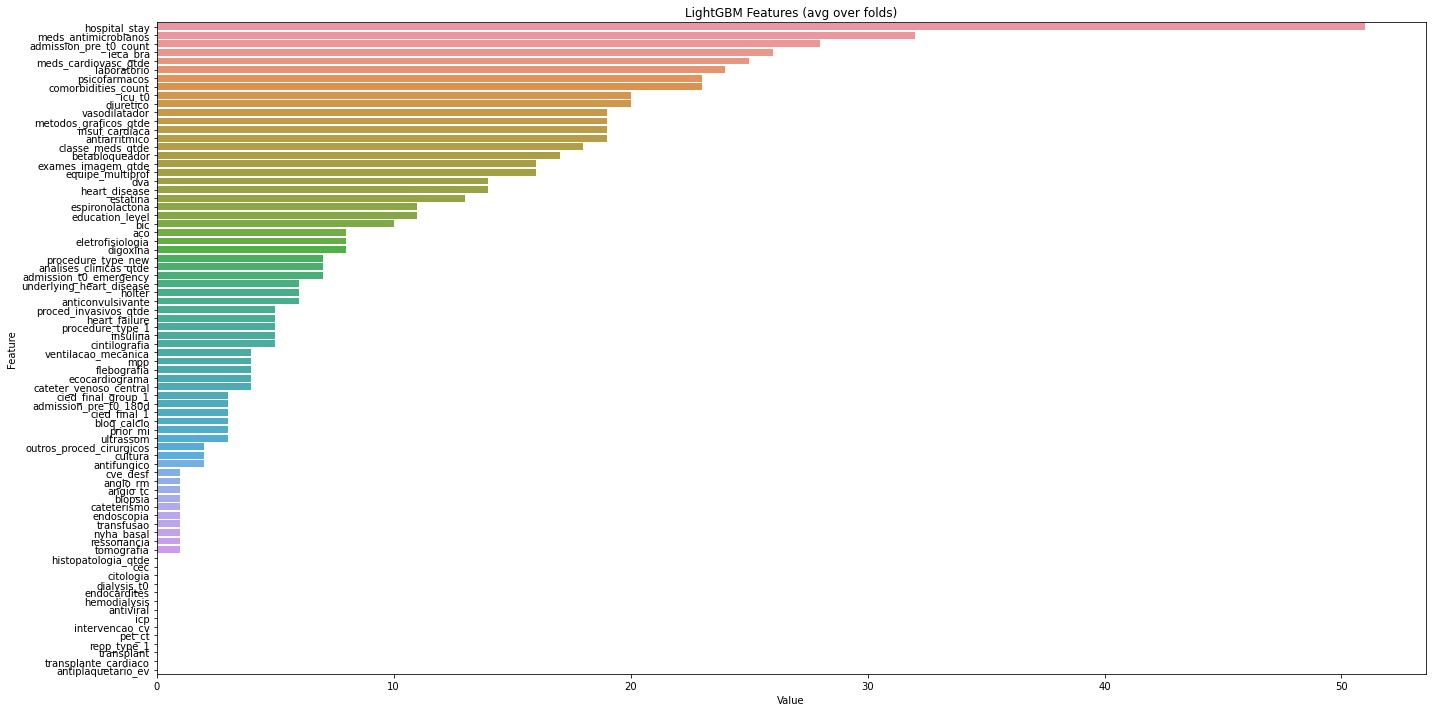

In [15]:
initial_model, _, feature_imp = fit_lightgbm(initial_features, plot_importance = True)

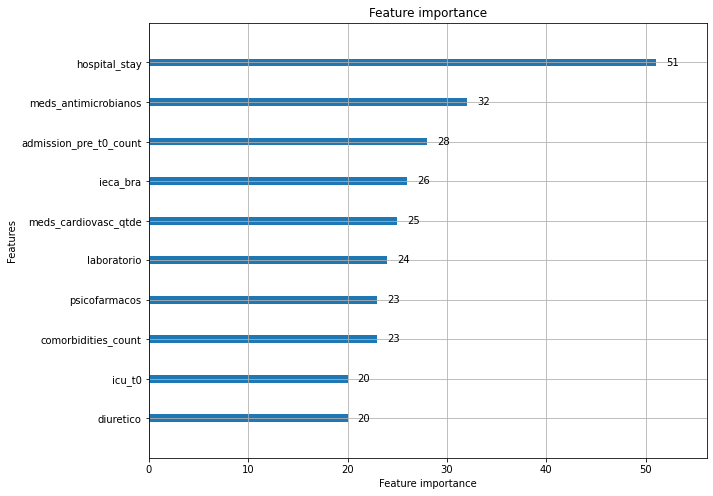

In [16]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)
lgb.plot_importance(initial_model, max_num_features = 10)
plt.show()

# Feature Selection

In [17]:
unimportant_features = feature_imp[feature_imp['Value'] == 0]['Feature'].tolist()

trimmed_features = list(set(initial_features) - set(unimportant_features))

print("Features with 0 importance: {}".format(len(unimportant_features)))
print("Trimmed number of features {}".format(len(trimmed_features)))

Features with 0 importance: 14
Trimmed number of features 62


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3183
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 62
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3183
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 62
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3183
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 62
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, th

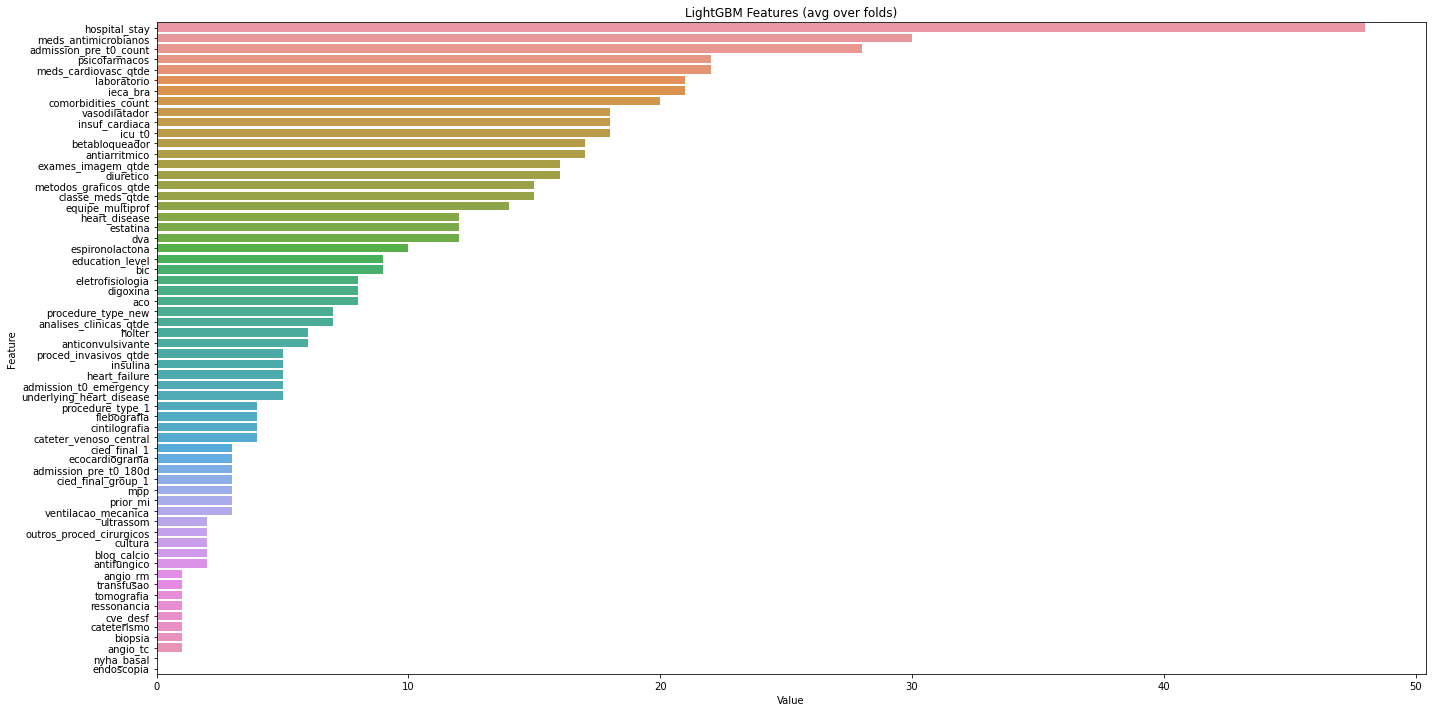

In [18]:
trimmed_model, trimmed_cv_results, _ = fit_lightgbm(trimmed_features, plot_importance = True)
n_estimators = len(trimmed_cv_results['auc-mean'])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data

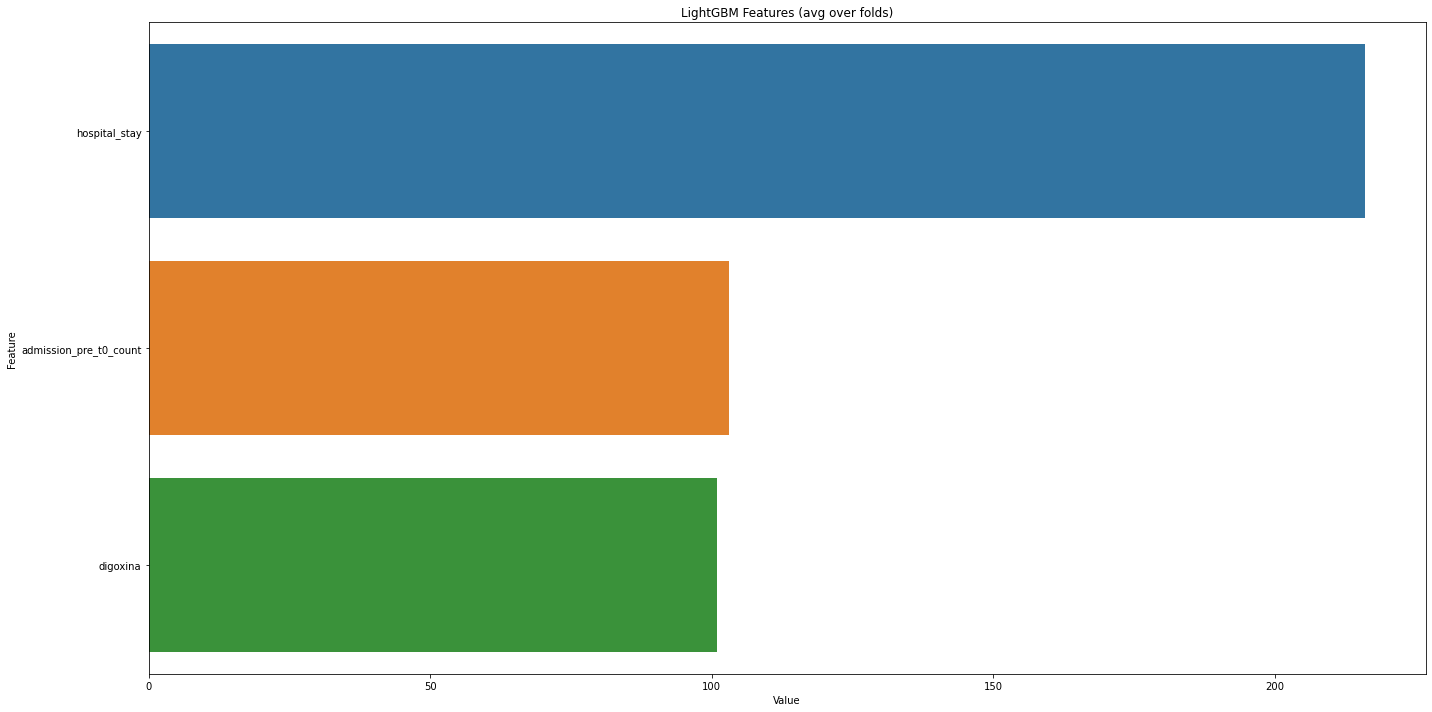

In [19]:
selected_features = ['hospital_stay', 'admission_pre_t0_count', 'digoxina']
selected_model, selected_cv_results, _ = fit_lightgbm(selected_features, plot_importance = True)
n_estimators = len(trimmed_cv_results['auc-mean'])

# Hyperparameter Tuning

In [20]:
# Hyperparameter grid
param_grid = {
    'num_leaves': list(range(5, 25)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.2), base = 10, num = 10)),
#     'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 10)),
    'is_unbalance': [True, False]
}

In [21]:
random_results = random_search(selected_features, param_grid, n_estimators)

  0%|          | 0/50 [00:00<?, ?it/s]

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the over

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[Ligh

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the over

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data po

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And i

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[Ligh

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the over

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the over

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the over

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[Ligh

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the over

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Info] Start training from score 0.038174
[LightGBM] [Info] Start training from score 0.038283
[LightGBM] [Info] Start training from score 0.038283
[LightGBM] [Info] Start training from score 0.038283
[LightGBM] [Info] Start training from score 0.038170
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[Ligh

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Info] Start training from score 0.038283
[LightGBM] [Info] Start training from score 0.038283
[LightGBM] [Info] Start training from score 0.038283
[LightGBM] [Info] Start training from score 0.038170
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of test

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wis

Found `n_estimators` in params. Will use it instead of argument
Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the over

Found `n_estimators` in params. Will use it instead of argument


In [22]:
df_search, tuned_hyperparameters = evaluate_search(random_results, name = 'random search')

The highest cross validation score from random search was 0.68762 found on iteration 10.

The best hyperparameters were:
{'colsample_bytree': 0.8666666666666667,
 'is_unbalance': True,
 'learning_rate': 0.20000000000000004,
 'n_estimators': 19,
 'num_leaves': 8,
 'reg_alpha': 0.9591836734693877,
 'reg_lambda': 0.36734693877551017,
 'subsample': 0.8888888888888888}


In [23]:
df_search

,num_leaves,learning_rate,reg_alpha,reg_lambda,colsample_bytree,subsample,is_unbalance,n_estimators,iteration,score
0,8,0.200000,0.959184,0.367347,0.866667,0.888889,True,19,10,0.687615
1,12,0.088108,0.265306,0.775510,0.955556,0.611111,False,19,12,0.68295
2,11,0.200000,0.040816,0.816327,1.000000,0.500000,True,19,35,0.681672
3,12,0.017100,0.734694,0.163265,1.000000,0.777778,True,19,17,0.672833
4,7,0.132747,0.428571,0.857143,0.644444,0.888889,False,19,18,0.672044
5,24,0.132747,0.857143,0.408163,0.911111,0.888889,False,19,3,0.671559
6,13,0.132747,0.306122,0.653061,0.600000,0.888889,True,19,6,0.671147
7,6,0.017100,0.346939,0.959184,0.644444,0.722222,True,19,2,0.670976
8,6,0.088108,0.040816,0.836735,0.955556,0.777778,False,19,13,0.670917
9,19,0.025763,0.693878,0.244898,0.911111,0.944444,True,19,11,0.670898


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 3
[LightGBM] [Info] Start training from score 0.038174
[LightGBM] [Info] Start training from score 0.038283
[LightGBM] [Info] Start training from score 0.038283
[LightGBM]

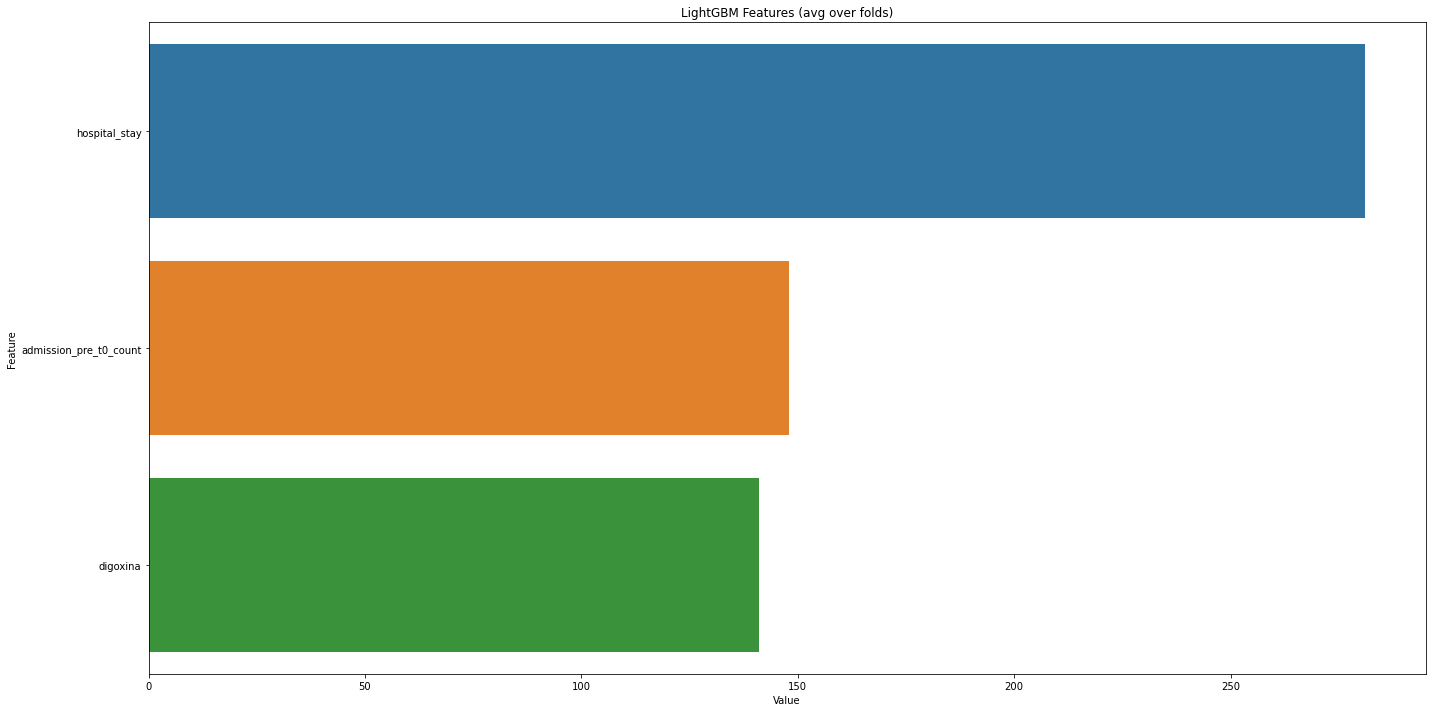

In [24]:
tuned_model, _, _ = fit_lightgbm(selected_features,
                                 hyperparameters=tuned_hyperparameters,
                                 early_stopping=False,
                                 plot_importance=True)